# Clustering Methods

> Weitong Zhang
> 2015011493
>
> <zwt15@mails.tsinghua.edu.cn>

## No empty subset in k-means

First of all, let's suppose that there are at least one empty subset $D_\phi$ generated by k-means clustering method, since in most of the case, $c \le n$ (otherwise, the k-means method is useless), therefore, the number of non-empty subset $c_{D\ne\phi}$ would be less than $n$

According to the pigeonhole principle, there are at least one subset which contains at least 2 samples, now lets set this subset as $D_\kappa$

Therefore, we can reconstruct the subset by moving the first sample $D_{\kappa0}$ to one empty subset, and keep the other subset fixed, therefore we remove an empty subset and get a subset with only one sample.

Let's assume that the original division strategy would lead to a loss determined by $J$, while the new one will have a loss defined by $J'$, we can easily conclude that:

$$J - J' = \sum_{i=0, D_{\kappa}}(x_i - m_{D_\kappa})^2 - \sum_{i=1, D_{\kappa'}}(x_i - m_{D_\kappa'})^2 \ge  \sum_{i=1, D_{\kappa}}(x_i - m_{D_\kappa})^2
- \sum_{i=1, D_{\kappa'}}(x_i - m_{D_\kappa'})^2$$

Note that it is obvious that the subset with only one sample have no loss

In the subset of $D{\kappa}'$, it is obvious that the center $m_{D_\kappa'}$ will lead to the lowest loss in function $\sum_{i=1, D_{\kappa'}}(x_i - m)^2$, that is to say, $\sum_{i=1, D_{\kappa}}(x_i - m_{D_\kappa})^2
- \sum_{i=1, D_{\kappa'}}(x_i - m_{D_\kappa'})^2 \ge 0$

Therefore, $J - J' \ge 0$, $J = J'$ only when in each subset, all of the samples are the same point, which makes any clustering method useless.

In conclusion, once we can find a division strategy with a empty subset, we can find one with this subset non-empty and improve the performance of the clustering, that is to say, no empty subset will be provided by k-means method.

## Programming

### Brief analysis of the time complexity

#### k-means method

For MNIST data, the similarity function between two sampls would be a $\mathcal O(m)$ algorithm, where $m = 784$.

Therefore, in each loop of k-means method, the algorithm will carry on an $\mathcal O(n*k)$ calculate, therefore, if there are total $T$ times loop executed, we can conclude that the time complexity would be $\mathcal O(T * n * k * m)$.

Therefore, the total time complexity of k-means method is $\mathcal O(n)$ with respect to $n$ (Regarding the $k,m,T$ as constant, where $T$ might be determined by the distribution of the samples)

An $\mathcal O(n)$ can manage $1\times 10^6$ samples in seconds in the most case (considering the big constant $T\times k\times m$)

####  Hierarhical clustering 

For MNIST data, the similarity function between two sampls would be a $\mathcal O(m)$ algorithm, where $m = 784$.

For each iteration, the time cost will vary from 1 to $\mathcal O(n^2)$, therefore, we can briefly conclude that the total time cost would be up to $\mathcal o(n^3)$

An $\mathcal O(n^3)$ can manage $1\times 10^2$ samples in seconds in the most case.

#### Spectral clustering

The time cost of construct the similarity matrix is $\mathcal O(n^2)$, and no other step have the longer time cost, therefore, the total time complexity is $\mathcal O(n^2)$

An $\mathcal O(n^2)$ can manage $1\times 10^3$ samples in seconds in the most case.

### Estimation Verification

In [1]:
import numpy as np
np.seterr('ignore')
from matplotlib import pyplot as plt
import time
class cluster:
    '''Base Class of all of the 3 cluter'''
    def __init__(self, k):
        '''
        @para k: number of cluster
        '''
        self.k = k
    def predict(self, X):
        '''
        @para X: samples x dimension array
        @ret y : samples x 1 array, range from 0 ~ k-1
        '''
        raise NotImplementedError

In [2]:
class k_means(cluster):
    def predict(self, X):
        y = np.array([index % self.k for index in range(X.shape[0])])
        while True:
            # construct the center of each class
            M = np.zeros((0,X.shape[1]))
            count = []
            for clazz in range(self.k):
                samples = X[y == clazz,:]
                count.append(samples.shape[0])
                samples_mean = np.mean(samples,axis=0)
                M = np.vstack((M,samples_mean))
                
            # Correct the cluster by sample
            if_continue = False
            for index in range(X.shape[0]):
                new_class = y[index]
                score_ori = count[y[index]] / (count[y[index]] - 1) * np.linalg.norm(X[index,:] - M[y[index],:])
                for clazz in range(self.k):
                    score_des = count[clazz] / (count[clazz] - 1) * np.linalg.norm(X[index,:] - M[clazz,:])
                    if score_des < score_ori:
                        score_ori = score_des
                        new_class = clazz
                        if_coutinue = True
                y[index] = new_class
                
            if not if_continue:
                break
        return y       

In [3]:
class hierarhical(cluster):
    def __init__(self,k,method='mean'):
        cluster.__init__(self,k)
        if method == 'mean':
            self.method = self.mean_dist
        elif method == 'min':
            self.method = self.min_dist
        elif method == 'max':
            self.method = self.max_dist
        else:
            raise NoMethodError
        
    def predict(self, X):
        T = self.build_up(X)
        leafs = [T]
        for _ in range(self.k - 1):
            is_cal = False
            for idx in range(len(leafs)):
                #split the leaf with the largest diameter
                if leafs[idx].ismerged:
                    d = self.diameter(X[leafs[idx].index,:])
                    if not is_cal or D < d:
                        best_idx = idx
                        D = d
                        is_cal = True
            leafs[best_idx].ismerged = False
            leafs.append(leafs[best_idx].lchild)
            leafs.append(leafs[best_idx].rchild)
        y = self.k * np.ones(X.shape[0])
        clazz = 0
        for leaf in leafs:
            if leaf.ismerged:
                y[leaf.index] = clazz
                clazz += 1
        return y
    
    def mean_dist(self,X1,X2):
        '''
        Calculate the mean distance of between the cluster
        @para X1,X2: samples x dimension
        '''
        count = 0
        total = 0
        for index1 in range(X1.shape[0]):
            for index2 in range(X2.shape[0]):
                total += np.linalg.norm(X1[index1,:] - X2[index2,:])
                count += 1
        return total / count
    
    def min_dist(self,X1,X2):
        '''
        Calculate the min distance of between the cluster
        @para X1,X2: samples x dimension
        '''
        is_cal = False
        for index1 in range(X1.shape[0]):
            for index2 in range(X2.shape[0]):
                d = np.linalg.norm(X1[index1,:] - X2[index2,:])
                if not is_cal or min_d > d:
                    min_d = d
                    is_cal = True
        return min_d
    
    def max_dist(self,X1,X2):
        '''
        Calculate the min distance of between the cluster
        @para X1,X2: samples x dimension
        '''
        is_cal = False
        for index1 in range(X1.shape[0]):
            for index2 in range(X2.shape[0]):
                d = np.linalg.norm(X1[index1,:] - X2[index2,:])
                if not is_cal or max_d < d:
                    max_d = d
                    is_cal = True
        return max_d
    
    def diameter(self,X):
        '''
        Calculate the diameter of a cluster
        @para X1: samples x dimension
        '''
        D = 0
        for index1 in range(X.shape[0]):
            for index2 in range(X.shape[0]):
                d = np.linalg.norm(X[index1,:] - X[index2,:])
                if d > D:
                    D = d
        return D
    
    class train_node:
        ''' Node of the train to be build'''
        def __init__(self,index,lchild,rchild):
            self.index = index
            self.lchild = lchild
            self.rchild = rchild
            self.ismerged = False
    
    def build_up(self,X):
        '''
        Build up the hierarhical tree
        @para X: samples x dimensions
        @ret  T: a build_up tree
        '''
        # Init a lot of tree nodes
        nodes = []
        for idx in range(X.shape[0]):
            nodes.append(self.train_node([idx],None,None))
            
        # Loop until all merged:
        while True:
            calculated = False
            for idx in range(len(nodes)):
                if nodes[idx].ismerged:
                    continue
                for idx_cmp in range(len(nodes)):
                    if nodes[idx_cmp].ismerged or idx == idx_cmp:
                        continue
                    score = self.method(X[nodes[idx].index,:],X[nodes[idx_cmp].index,:])
                    if not calculated or score < best_score:
                        best_score = score
                        calculated = True
                        best1 = idx
                        best2 = idx_cmp
                    calculated = True
            if not calculated:
                break
            # merge the two best one
            nodes[best1].ismerged = True
            nodes[best2].ismerged = True
            nodes.append(self.train_node(nodes[best1].index + nodes[best2].index,nodes[best1],nodes[best2]))
            
        for node in nodes:
            if not node.ismerged:
                node.ismerged = True
                return node

In [4]:
class spectral(cluster):
    def __init__(self,k):
        cluster.__init__(self,k)
        self.sigma = 1
    def predict(self, X):
        W = np.zeros((X.shape[0],X.shape[0]))
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                delta = X[i,:] - X[j,:]
                W[i,j] = np.exp(-np.matmul(delta.T,delta)/2 / self.sigma)
        d = np.sum(W,axis=0)
        D = np.diag(d)
        DD = np.diag(np.true_divide(1, np.sqrt(d)))
        L = np.matmul(np.matmul(DD,D - W),DD)
        w,v = np.linalg.eig(L)
        W= np.vstack((w,v))
        W = W[:,W[0].argsort()]  
        data = W[1:,:self.k]
        c = k_means(self.k)
        return c.predict(data)

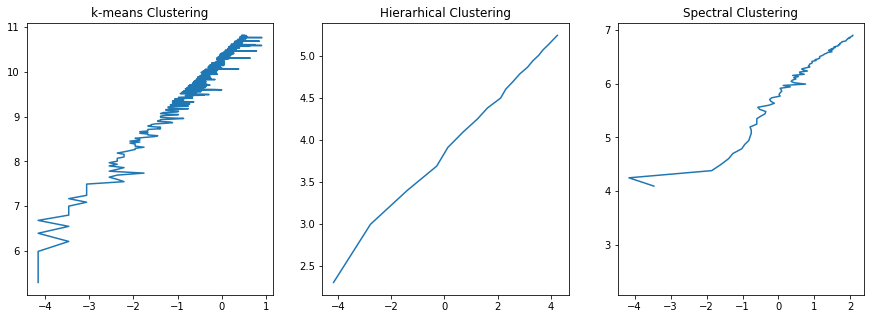

In [5]:
plt.rcParams["figure.figsize"] = [15,5]

# k-means
plt.subplot(1,3,1)
rec = []
num = range(100,50000,100)
for n in num:
    c = k_means(4)
    a = time.clock()
    c.predict(np.random.rand(n,2))
    rec.append(time.clock() - a)
plt.plot(np.log(np.array(rec)),np.log(np.array(num)))
plt.title('k-means Clustering')

# hierarhical
plt.subplot(1,3,2)
rec = []
num = range(10,200,10)
for n in num:
    c = hierarhical(4)
    a = time.clock()
    c.predict(np.random.rand(n,2))
    rec.append(time.clock() - a)
plt.plot(np.log(np.array(rec)),np.log(np.array(num)))
plt.title('Hierarhical Clustering')

# spectral
plt.subplot(1,3,3)
rec = []
num = range(10,1000,10)
for n in num:
    c = spectral(4)
    a = time.clock()
    c.predict(np.random.rand(n,2))
    rec.append(time.clock() - a)
plt.plot(np.log(np.array(rec)),np.log(np.array(num)))
plt.title('Spectral Clustering')
plt.show()

#### Experiment Results

The plot above is the $N~T$ plot of three algorithm in random input. The vertical axis is $\ln N$ and the horizontal axis stands for $\ln T$. We can find out that 

- k-means: $\ln N \approx \ln T + b\ \Rightarrow T = \mathcal O(N)$
- Hierarhical: $\ln N \approx 0.25 \ln T + b \ \Rightarrow T = \mathcal O(N^4)$
- Spectral: $\ln N \approx 0.5\ln T + b \ \Rightarrow T = \mathcal O(N^2)$

The time complexity is the same with our estimation in k-means and Spectral. The time complexity for hierarhical is a little bit greater than the estimation (but this might because the stupid implementation)

#### Speed up methods

There are indeed some speed up method using in the hierarhical method, for example, we can use the 'distance from the center' to replace the 'mean distance', which will speed up the calculate between classes from $\mathcal O(n^2)$ to $\mathcal O(n)$

### Testing with MNIST dataset

#### Data set split

In order to speed up the calculation, we use 100 samples for hierarhical clustering, 1,000 samples for spectral clustering and 10,000 samples for k-means clustering method

In [6]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
mnist = fetch_mldata('MNIST original')
data = mnist['data'] / 255
label = mnist['target']
_, X_hierarhical, _, y_hierarhical = train_test_split(data, label, test_size=100)
_, X_spectral, _, y_spectral = train_test_split(data, label, test_size=1000)
_, X_k_means, _, y_k_means = train_test_split(data, label, test_size=10000)

#### Solving k-means

##### Deal with the initial sensitive

In our implementation of k-means, we just put every point into a random cluster simply, however, we can initial the k-means algorithm with a certain method called k-means++, which select the first cluster center randomly, and select the following cluster center as far from the existing center as possible. k-means++ method could refine the initial to a great extent.

##### $J_e$ with NMI

In [7]:
def Je(X,y,k):
    '''
    Calc the J_e for k-means
    @para X: samples x dimensions
    @para y: samples x 1
    @para k: numbers of cluster
    @ret Je: \sum|x-m|^2
    '''
    M = np.zeros((0,X.shape[1]))
    for clazz in range(k):
        samples = X[y == clazz,:]
        samples_mean = np.mean(samples,axis=0)
        M = np.vstack((M,samples_mean))
    loss = 0
    for idx in range(X.shape[0]):
        delta = X[idx,:] - M[y[idx],:]
        loss += np.matmul(delta.T, delta)
    return loss / X.shape[0]

In [8]:
# Je and NMI for k_means
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
c = k_means(10)
y = c.predict(X_k_means)
je = Je(X_k_means,y,10)
nmi = NMI(y_k_means,y)
print ('J_e = {:.3f}, NMI = {:5f}'.format(je,nmi))

J_e = 44.309, NMI = 0.276878


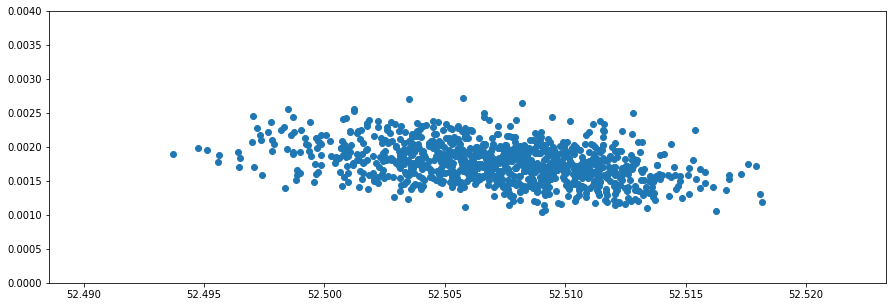

In [9]:
# Is Je and NMI match?
# random labeling
je = []
nmi = []
for _ in range(1000):
    y_random = np.random.randint(10,size=(10000,))
    je.append(Je(X_k_means,y_random,10))
    nmi.append(NMI(y_k_means,y_random))

plt.scatter(np.array(je),np.array(nmi))
plt.ylim((0,0.004))
plt.show()

##### Is Je and NMI match?

From the random testing, we can find that $J_e$ and NMI does not match exactly, however, the problem of random testing is that the NMI score is too low. In fact, when the cluster is good enough to get the lower $J_e$, e.g. k-means can generate the label with $J_e < 45$ while the random $J_e$ is about $J_e > 50$. In this relatively 'greater' scale, a lower $J_e$ might lead to a greater NMI

#### Solving hierarchical clustering

Since using python instead of MATLAB, we could just implement some simple linkage method manually instead using the linking method provided by MATLAB. According to the experiment, it seems that the max linkage method is the best linkage method among the 3 method provided below

In [10]:
# mean distance:
for method in ['mean','min','max']:
    c = hierarhical(10,method)
    y_predict = c.predict(X_hierarhical)
    nmi = NMI(y_hierarhical,y_predict)
    print ('Using {} linkage method, NMI = {}'.format(method,nmi))

Using mean linkage method, NMI = 0.5523632982305717
Using min linkage method, NMI = 0.20548233411537595
Using max linkage method, NMI = 0.5475338769365315


#### Solving spectral clustering

It is easily to find out that the kNN similarity graph is time cost and not recommended. We have already carried out some simple experiment (which is not included in this notebook) to carry out kNN similarity matrix. According to the previous expermients, we can conclude that using the gauss distance is a good idea.

The following code is dealing with the selection of $\sigma$ in $s(i,j) = \exp(\frac{d(i,j)^2}{2\sigma})$

According to the experiment, it seems that the $sigma = 0.3 ~ 3$ is ok.

In [11]:
c = spectral(10)
for sigma in [0.1,0.3,1,3]:
    c.sigma = sigma
    y_predict = c.predict(X_spectral)
    nmi = NMI(y_spectral,y_predict)
    print ('Using sigma = {}, NMI = {}'.format(sigma,nmi))

Using sigma = 0.1, NMI = 0.18529179592749784
Using sigma = 0.3, NMI = 0.08539695907142038
Using sigma = 1, NMI = 0.2840494648254438
Using sigma = 3, NMI = 0.2977927319444501


> CLAIM:
>
> Here, we use the NMI function provided by sklearn, however, it seems that a larger data set might provided lower NMI, it might because a larger data set is not easy to be divided.

### Choosing the right $k$

For all method, we can find out that the $J_e$ loss is decreasing with the increasment of $k$. We choose the $k$ where the second-order differential is at its largest:

$$k = \arg\max_iJ_e(i+1) - 2J_e(i) + J_e(i-1)$$

In [12]:
def find_k(method,method_name,X_method):
    je = []
    for k in range(5,15):
        c = method(k)
        y_predict = c.predict(X_method).astype(int)
        #print(y_predict)
        je.append(Je(X_method,y_predict,k))
    sec_diff = []
    for idx in range(len(je)-2):
        sec_diff.append(je[idx + 2] - 2 * je[idx + 1] + je[idx])
    print ('For {}, the best k is {}'.format(method_name, np.argmax(np.array(sec_diff)) + 6))
find_k(k_means,'k-means',X_k_means)
find_k(hierarhical,'hierarhical',X_hierarhical)
find_k(spectral,'spectral',X_spectral)

For k-means, the best k is 12
For hierarhical, the best k is 6


/home/zeroweight/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


For spectral, the best k is 12


### Algorithm to choose

According to the above analysis, we would like to choose the k-means method, since it is fast and easy to use. Moreover, many method such like k-means++ will solve the problem of initial sensitive.